# Social Reward Second Level Analyses

## Set Up

### Import packages

In [4]:
import os
import glob
import pandas as pd
import numpy as np

from matplotlib.gridspec import GridSpec

# Import cerebellum packages
import matplotlib.pyplot as plt
import SUITPy.flatmap as flatmap

from nilearn.glm.second_level import make_second_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img, cluster_level_inference

import importlib

import helpful_functions
importlib.reload(helpful_functions)

<module 'helpful_functions' from '/Users/haroonpopal/Library/CloudStorage/GoogleDrive-hpopal@umd.edu/My Drive/dscn_lab/projects/scon_social_reward/code/neuron_code/helpful_functions.py'>

### Set directories and import subject data

In [7]:
subjs_list

['sub-SCN101',
 'sub-SCN102',
 'sub-SCN103',
 'sub-SCN104',
 'sub-SCN105',
 'sub-SCN106',
 'sub-SCN107',
 'sub-SCN108',
 'sub-SCN109',
 'sub-SCN110',
 'sub-SCN112',
 'sub-SCN117',
 'sub-SCN118',
 'sub-SCN119',
 'sub-SCN120',
 'sub-SCN121',
 'sub-SCN122',
 'sub-SCN123',
 'sub-SCN124',
 'sub-SCN125',
 'sub-SCN126',
 'sub-SCN127',
 'sub-SCN128',
 'sub-SCN129',
 'sub-SCN133',
 'sub-SCN134',
 'sub-SCN135',
 'sub-SCN141',
 'sub-SCN142',
 'sub-SCN143',
 'sub-SCN144',
 'sub-SCN145',
 'sub-SCN147',
 'sub-SCN149',
 'sub-SCN151',
 'sub-SCN152',
 'sub-SCN154',
 'sub-SCN155',
 'sub-SCN157',
 'sub-SCN158',
 'sub-SCN159',
 'sub-SCN160',
 'sub-SCN164',
 'sub-SCN165',
 'sub-SCN168',
 'sub-SCN169',
 'sub-SCN171',
 'sub-SCN172',
 'sub-SCN173',
 'sub-SCN177',
 'sub-SCN181',
 'sub-SCN182',
 'sub-SCN183',
 'sub-SCN184',
 'sub-SCN185',
 'sub-SCN186',
 'sub-SCN187',
 'sub-SCN189',
 'sub-SCN190',
 'sub-SCN195',
 'sub-SCN196',
 'sub-SCN197',
 'sub-SCN198',
 'sub-SCN199',
 'sub-SCN200',
 'sub-SCN201',
 'sub-SCN2

In [10]:
subjs_info

,age,gender,group
participant_id,,,
sub-SCN101,13.29,2.0,1.0
sub-SCN102,12.38,1.0,1.0
sub-SCN103,11.55,2.0,1.0
sub-SCN104,12.42,1.0,1.0
sub-SCN105,14.39,4.0,2.0
...,...,...,...
sub-SCN324,11.29,1.0,1.0
sub-SCN325,13.26,1.0,1.0
sub-SCN326,12.57,1.0,2.0


In [12]:
#bids_dir = '/data/projects/social_doors/'
local = True

if local:
    bids_dir = '/Users/haroonpopal/hpopal@umd.edu - Google Drive/My Drive/dscn_lab/projects/scon_social_reward/'
else:
    bids_dir = '/data/neuron/SCN/SR/'


os.chdir(bids_dir)

data_dir = os.path.join(bids_dir, 'derivatives','SR_univariate')
outp_dir = data_dir+'group/'

# Import scan info for runs that passed QC
subjs_scan_info = pd.read_csv(bids_dir+'/derivatives/participants-qc-min_task_errors.csv')

# Create a participant list for only those with good scans
subjs_list = list(subjs_scan_info['participant_id'].unique())
subjs_list.sort()

# Import other participant info like demographics
subjs_info = pd.read_csv(bids_dir+'participants.tsv', sep='\t', index_col=0)
#subjs_info = subjs_info.rename(columns={'participant_id': 'subject_label'})

# Filter for only participants with good scan data
subjs_info = subjs_info.loc[subjs_list]

# Rename group IDs
subjs_info['group'] = subjs_info['group'].map({1: 'not_asd', 2: 'asd'})

# Reset index to make participant IDs a column
subjs_info = subjs_info.reset_index()


subjs_info_typ = subjs_info[subjs_info['group']=='not_asd']
subjs_info_asd = subjs_info[subjs_info['group']=='asd']

#subjs_list = subjs_info.index.to_list()
subjs_list_typ = subjs_info_typ['participant_id'].to_list()
subjs_list_asd = subjs_info_asd['participant_id'].to_list()

print('Found '+str(len(subjs_list_typ))+' non-autistic participants')
print('Found '+str(len(subjs_list_asd))+' autistic participants')

Found 102 non-autistic participants
Found 38 autistic participants


## Non-Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

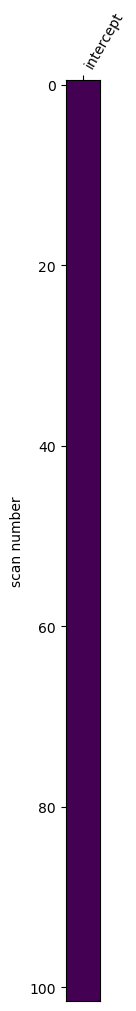

In [13]:
design_matrix = make_second_level_design_matrix(subjs_list_typ)

plot_design_matrix(design_matrix)

In [15]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['pos_psVc_f', 'all_psVpd_i']
group = 'not_asd'
tasks = ['SR']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_typ.copy()
        temp_file_list = []
        for subj in subjs_list_typ:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast for '+str(len(temp_file_list))+' subjects')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)
        #z_map_thresh_clust = cluster_level_inference(z_map_thresh, alpha=0.05)
        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
        #z_map_thresh_clust.to_filename(os.path.join(data_dir,'group',
        #                           'zmap_'+group+'_'+task+'_'+contrast+'_'+mc+'-'+str(alpha)+'_clust-0.05'+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold
        

Calculating group pos_psVc_f contrast for 101 subjects
Calculating group all_psVpd_i contrast for 101 subjects


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.749756155068799. But, you have given threshold=inf.
  stat_img = threshold_img(


### Similar Peer vs Computer Positive Feedback
This contrast examines the basic social reward signal.

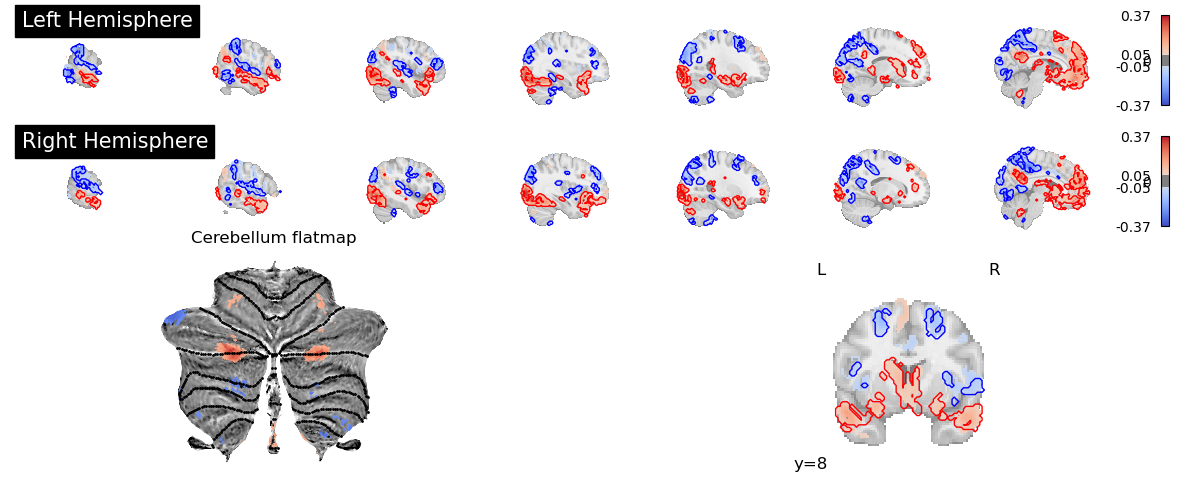

In [16]:
filename = data_dir+'/group/'+'not_asd_SR_pos_psVc_f'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

**Note about visualization:** Uncorrected maps are displayed with significant clusters outlined in bold (not including the cerebellum flatmap). 

### Similar Peer vs Dissimilar Peer Cue
This contrast examines the cue phase for similar peer vs dissimilar peer. This contrast tries to get at whether participants learn that there is a similar and dissimilar peer and whether an anticipation signal may be present for the different peers. 

There was greated activation for similar peer positive feedback compared to computer positive feedback in the mPFC, ventral striatum, insula(?), ATL, PCC, the ventral visual stream, and medial Crus I/II. There was greater computer postiive feedback in the precuneus, dlPFC, STG, and lobule VIIb of the cerebellum. 

**Haroon's interpretation**: DMN vs frontoparietal control network

/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


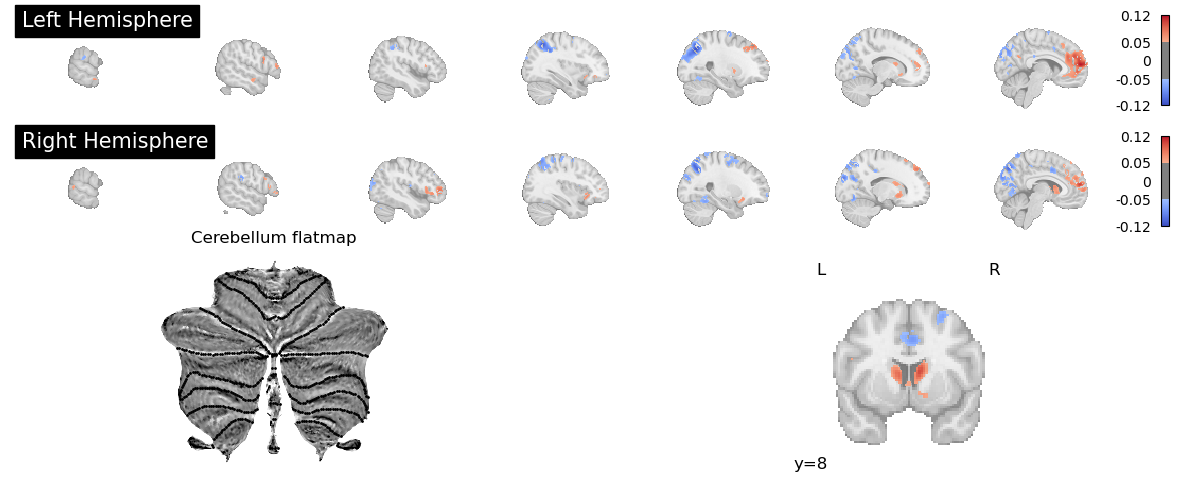

In [17]:
filename = data_dir+'/group/'+'not_asd_SR_all_psVpd_i'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

No significant results. But uncorrected map shows greater activation in the ventral striatum and mPFC for the similar peer and greater activation in the IPL(?)/IPS(?) for dissimilar peer.

## Autistic Adolescents

<Axes: label='conditions', ylabel='scan number'>

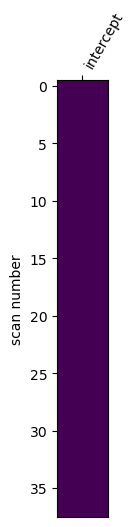

In [18]:
design_matrix = make_second_level_design_matrix(subjs_list_asd)

plot_design_matrix(design_matrix)

In [19]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['pos_psVc_f', 'all_psVpd_i']
group = 'asd'
tasks = ['SR']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list_asd.copy()
        temp_file_list = []
        for subj in subjs_list_asd:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        print('Calculating group '+contrast+' contrast for '+str(len(temp_file_list))+' subjects')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        contrast_stats = model.compute_contrast(output_type='all')
        z_map = contrast_stats['z_score']
        e_map = contrast_stats['effect_size']

        z_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap.nii.gz'))
        e_map.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_effect.nii.gz'))
            
        # Multiple Comparisons Correction
        z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

        z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                   group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))
            
        threshold_data[group+'_'+task+'_'+contrast+'_zmap_'+mc+'-'+str(alpha)] = threshold

Calculating group pos_psVc_f contrast for 37 subjects


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.433554662476249. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group all_psVpd_i contrast for 37 subjects


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.476563451227829. But, you have given threshold=inf.
  stat_img = threshold_img(


### Similar Peer vs Computer Positive Feedback

/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


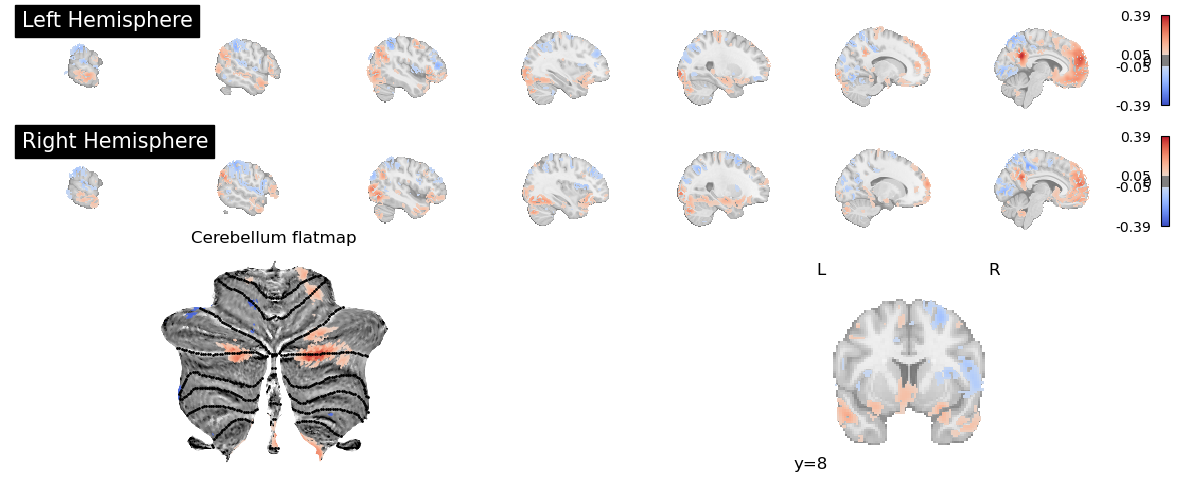

In [20]:
filename = data_dir+'/group/'+'asd_SR_pos_psVc_f'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

No significant results, but uncorrected results look similar to the neurotypical participants. 

### Similar Peer vs Dissimilar Peer Cue

/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


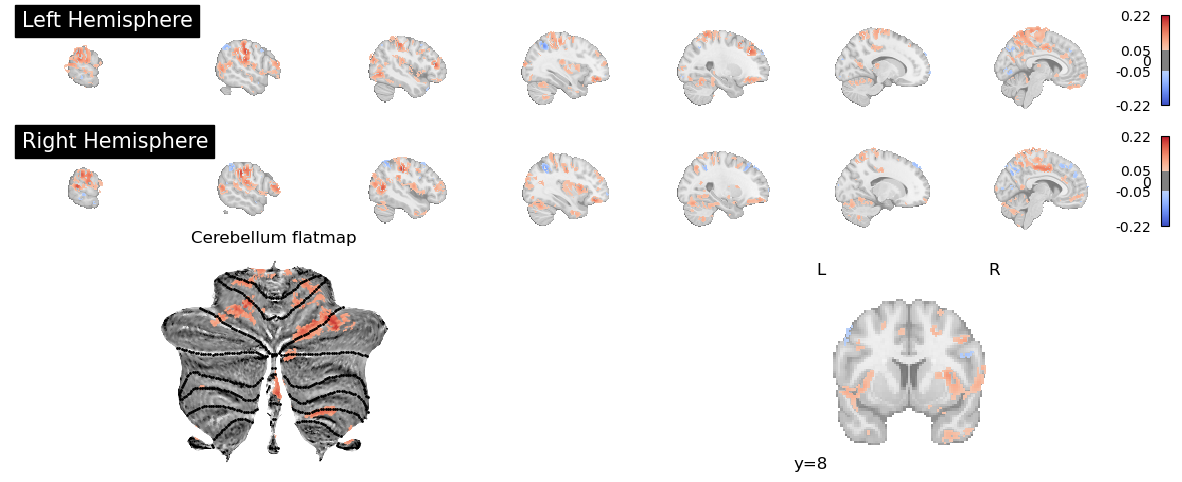

In [21]:
filename = data_dir+'/group/'+'asd_SR_all_psVpd_i'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

No significant results. Uncorrected results are not promising. 

## All Subjects

/var/folders/bj/bjn1471s0735c7771plnzsz00000gn/T/ipykernel_2197/1405823549.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  subjs_info_num = subjs_info_num.replace({'group': {'asd': -1, 'not_asd': 1}})


<Axes: label='conditions', ylabel='scan number'>

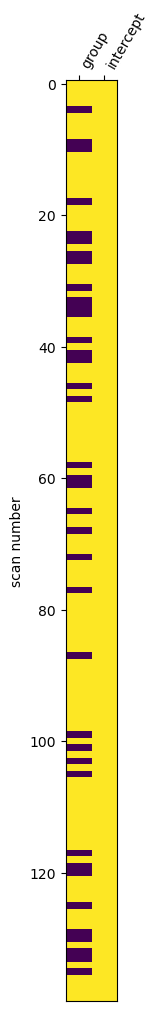

In [22]:
subjs_info_num = subjs_info.copy()
subjs_info_num = subjs_info_num.replace({'group': {'asd': -1, 'not_asd': 1}})
subjs_info_num = subjs_info_num.rename({'participant_id': 'subject_label'}, axis='columns')

# Drop irrelevant columns
subjs_info_num = subjs_info_num.drop(columns=['age','gender'])

design_matrix = make_second_level_design_matrix(subjs_list, subjs_info_num)

plot_design_matrix(design_matrix)

In [23]:
mni_mask = bids_dir+"/derivatives/fmriprep/sub-SCN101/anat/sub-SCN101_space-MNIPediatricAsym_cohort-5_res-2_label-GM_probseg_bin.nii.gz"

contrasts=['pos_psVc_f', 'all_psVpd_i']
contrasts_2nd = ['intercept', 'group']
group = 'all'
tasks = ['SR']
alpha = 0.05
mc = 'fdr'


threshold_data = {}

for task in tasks:
    for contrast in contrasts:
        temp_subj_list = subjs_list.copy()
        temp_file_list = []
        for subj in subjs_list:
            temp_file = glob.glob(os.path.join(data_dir,subj,
                                               'zmap_'+task+'_'+contrast+'_run-all.nii.gz'))
            if len(temp_file) == 0:
                temp_subj_list.remove(subj)
                continue
            temp_file_list.append(temp_file[0])
        temp_file_list.sort()
        
        # Filter subjs info data frame for only participants that have data
        temp_subjs_info_num = subjs_info_num[subjs_info_num['subject_label'].isin(temp_subj_list)]
        
        print('Calculating group '+contrast+' contrast for '+str(len(temp_file_list))+' subjects')
        
        design_matrix = make_second_level_design_matrix(temp_subj_list, 
                                                        temp_subjs_info_num)
        model = SecondLevelModel(mask_img=mni_mask, smoothing_fwhm=8.0)
        model.fit(temp_file_list, design_matrix=design_matrix)
        
        for contrast_2nd in contrasts_2nd:
            contrast_stats = model.compute_contrast(contrast_2nd, output_type='all')
            z_map = contrast_stats['z_score']
            e_map = contrast_stats['effect_size']

            z_map.to_filename(os.path.join(data_dir,'group',
                              group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap.nii.gz'))
            e_map.to_filename(os.path.join(data_dir,'group',
                              group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_effect.nii.gz'))
            
            # Multiple Comparisons Correction
            z_map_thresh, threshold = threshold_stats_img(z_map, alpha=alpha, height_control=mc)

            z_map_thresh.to_filename(os.path.join(data_dir,'group',
                                       group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap_'+mc+'-'+str(alpha)+'.nii.gz'))

            threshold_data[group+'_'+task+'_'+contrast+'_'+contrast_2nd+'_zmap_'+mc+'-'+str(alpha)] = threshold

Calculating group pos_psVc_f contrast for 138 subjects


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 3.7979655952804543. But, you have given threshold=inf.
  stat_img = threshold_img(


Calculating group all_psVpd_i contrast for 138 subjects


/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 3.92170626586013. But, you have given threshold=inf.
  stat_img = threshold_img(
/opt/anaconda3/lib/python3.11/site-packages/nilearn/glm/thresholding.py:303: UserWarning: The given float value must not exceed 4.081430506194938. But, you have given threshold=inf.
  stat_img = threshold_img(


### Group differences 
Where non-autistic > autistic

#### Similar Peer vs Computer Positive Feedback

/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


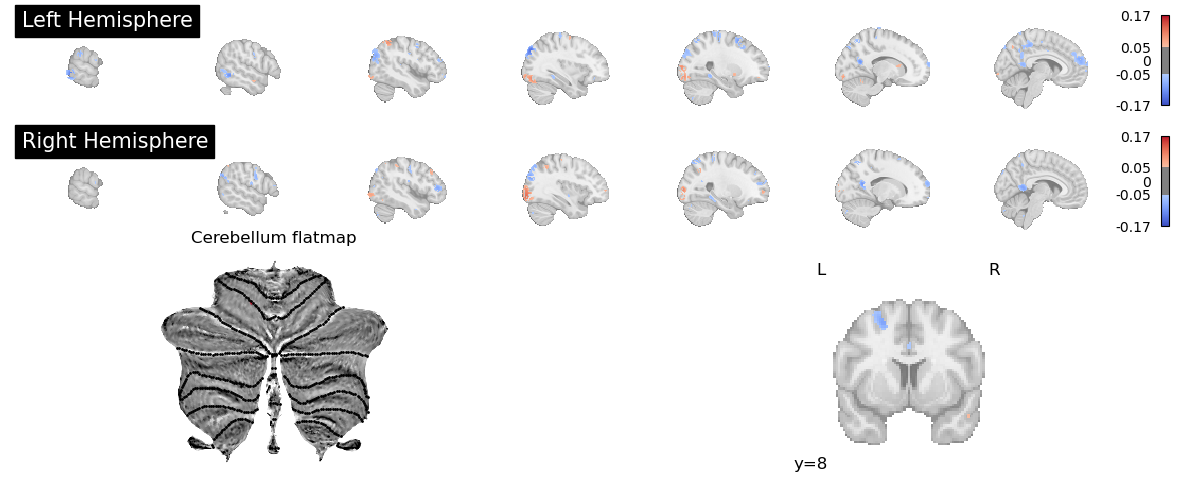

In [24]:
filename = data_dir+'/group/'+'all_SR_pos_psVc_f_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

No significant results

#### Similar Peer vs Dissimilar Peer Cue

/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)
/opt/anaconda3/lib/python3.11/site-packages/nilearn/plotting/displays/_slicers.py:366: UserWarning: empty mask
  self._map_show(img, type="contour", threshold=threshold, **kwargs)


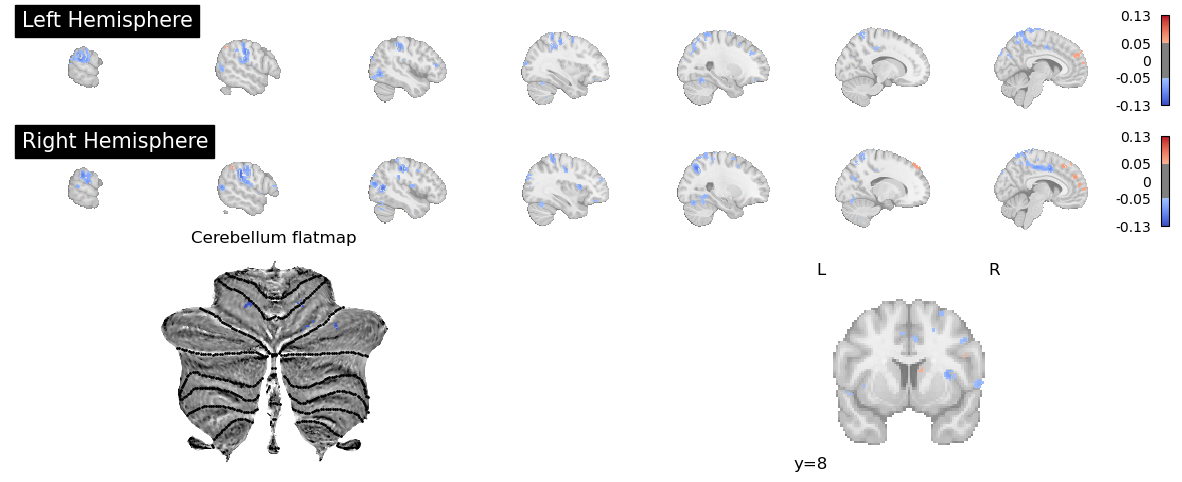

In [25]:
filename = data_dir+'/group/'+'all_SR_all_psVpd_i_group'

helpful_functions.plot_transparent_threshold(filename, thresh=.05)

No significant results